This colab notebook will help in understanding the different variations of BERT and how they respond to similarity metric like cosine similarity

# Importing the Libraries

In [1]:
# Block 1: Load required packages

!pip install transformers
!pip install sentence-transformers


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 51.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 200.1/200.1 kB 25.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 55.4 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.0/86.0 kB 4.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 26.3 MB/s eta 0:00:00
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.2-py3-none-any.whl size=125942 sha256=393a7922fb069b3c103fd84c4d1b58b1677bde66de4d71bbb59085cc4235c9ff
  Stored in directory: /root/.cache/pip/wheels/71/67/06/162a3760c40d74dd40bc855d527008d26341c2b0ecf3e8e11f
Successfully built sentence-transformers


In [2]:
# Block 2: Import required packages

import re
# import umap
import nltk
import numpy as np
import pandas as pd
import torch
import transformers as ppb 
from collections import Counter
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity
nltk.download('stopwords')
nltk.download('wordnet')
stop_words = set(nltk.corpus.stopwords.words('english'))
# model = KeyBERT('distilbert-base-nli-mean-tokens')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [3]:
# Block 3: Load pre-trained BERT Model and Tokenzier

model_class, tokenizer_class, pretrained_weights = (ppb.BertModel, ppb.BertTokenizer, 'bert-base-uncased')
tokenizer = tokenizer_class.from_pretrained(pretrained_weights)

In [4]:
# Block 4: Load and preprocess the dataset by removing Stopwords

def prepare_data(stopwords):
    try: 
        df = pd.read_csv('/content/raw_data.csv',encoding='ISO-8859-1')
    except Exception as e:
        print(str(e))

    df = df[['Title','Abstract']]
    df = df.dropna().drop_duplicates(subset=['Abstract'])
    df = df.dropna().drop_duplicates(subset=['Title'])
    df['Abstract'] = df['Abstract'].apply(remove_stop_lemmatize, args=(stopwords,))
    df = df[df['Abstract'].str.len() > 150].reset_index()
    df['index']    = df.index
    df['abstract_list'] =  df['Abstract'].apply(lambda x : x.split(' '))
    df['abstract_list_len'] =  df['abstract_list'].apply(lambda x : len(x))
    df['abstract_list_trunc'] =  df['abstract_list'].apply(lambda x : x[0:400])
    df['aabstract_list_trunc_len'] =  df['abstract_list_trunc'].apply(lambda x : len(x))
    df['final_text'] = df['abstract_list_trunc'].apply(lambda x : ' '.join(x))
    return df



In [5]:
# Block 5: Lemmatize the Tokens

def remove_stop_lemmatize(text, stopwords):
    text = text.replace('-',' ')
    text = re.sub (r'([^a-zA-Z ]+?)', '', text)
    if stopwords:
        text = text.split(' ')
        return ' '.join(lemmatizer.lemmatize(word.lower()) for word in text if word.lower() not in stop_words)
    else:
        return text

In [6]:
# Block 6: Inputting text data into a BERT Model

n_data = prepare_data(stopwords=False)
text = n_data['final_text'][0]
marked_text = "[CLS] " + text + " [SEP]"
# Tokenize our sentence with the BERT tokenizer.
tokenized_text = tokenizer.tokenize(marked_text)
# Print out the tokens.
# n_data['final_text'] = "[CLS] " + n_data['final_text'] + " [SEP]"
n_data['tokenized_marked'] = n_data['final_text'].apply((lambda x: tokenizer.tokenize(x)))
n_data['tokenized'] = n_data['final_text'].apply((lambda x: tokenizer.encode(x)))
max_len = 0
for i in n_data['tokenized'].values:
    if len(i) > max_len:
        max_len = len(i)
n_data['tokenized_padded'] = n_data['tokenized'].apply((lambda x: x + ([0]*(max_len - len(x)))))
n_data['hashed_tokens'] = n_data['tokenized_marked'].apply((lambda x: [i for i in x if "##" in i]))
n_data['hashed_tokens_len'] = n_data['hashed_tokens'].apply((lambda x: len(x)))
n_data['tokenized_padded_len'] = n_data['tokenized_padded'].apply((lambda x: len(x)))
n_data['segment'] = n_data['tokenized'].apply((lambda x: [1 for i in range(len(x))]))
n_data['segment_padded'] = n_data['segment'].apply((lambda x: x + ([0]*(max_len - len(x)))))
n_data['segment_padded_len'] = n_data['segment_padded'].apply((lambda x: len(x)))
# print (tokenized_text)

The original word has been split into smaller subwords and characters. This is because Bert Vocabulary is fixed with a size of ~30K tokens. Words that are not part of vocabulary are represented as subwords and characters.

(array([109., 154., 114.,  58.,  23.,   7.,   0.,   0.,   0.,   1.]),
 array([  0. ,  10.5,  21. ,  31.5,  42. ,  52.5,  63. ,  73.5,  84. ,
         94.5, 105. ]),
 <BarContainer object of 10 artists>)

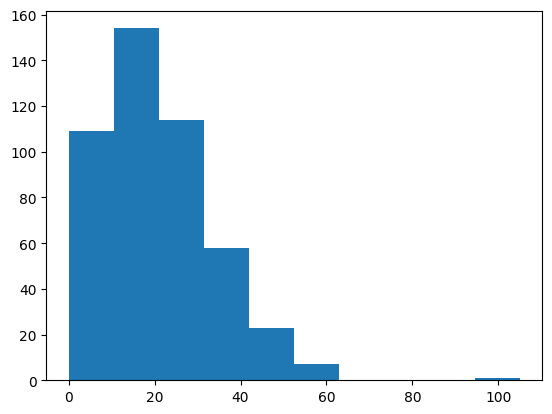

In [7]:
# Block 7: Plot the histogram of Hashed Token Length

plt.hist(n_data['hashed_tokens_len'])

Next we need to convert our data to tensors(input format for the model) and call the BERT model. 

# Checking various pooling schemes

In [8]:
# Block 8: Check pooling schemes

similar_set    = [[0,5],[17,57],[424,426],[120,121]]
dissimilar_set = [[0,115],[26,28],[1,119],[0,1]]
print('@@@@@@@@@@@@@@@@  Similar pair of text  @@@@@@@@@@@@@@@@@@@@')
similar_dict = {}
count = 1 
for i in similar_set:
    similar_dict[count] = {}
    similar_dict[count][i[0]] = {}
    similar_dict[count][i[1]] = {}
    for j in i:
        print('Title of paper {}'.format(n_data['Title'][j]))
        similar_dict[count][j]['token']  = torch.tensor(np.array([i  for i in n_data['tokenized_padded'][j]]).reshape(1,len(n_data['tokenized_padded'][j]))).to(torch.int64) 
        similar_dict[count][j]['att']    = torch.tensor(np.array([i  for i in n_data['segment_padded'][j]]).reshape(1,len(n_data['segment_padded'][j]))).to(torch.int64) 
    count = count + 1
    print('---------------------------------------------------------------------------------')

print('@@@@@@@@@@@@@@@  Dissimilar pair of text   @@@@@@@@@@@@@@@@@@')
dissimilar_dict = {}
count = 1 
for i in dissimilar_set:
    dissimilar_dict[count] = {}
    dissimilar_dict[count][i[0]] = {}
    dissimilar_dict[count][i[1]] = {}
    for j in i:
        print('Title of paper {}'.format(n_data['Title'][j]))
        dissimilar_dict[count][j]['token']  = torch.tensor(np.array([i  for i in n_data['tokenized_padded'][j]]).reshape(1,len(n_data['tokenized_padded'][j]))).to(torch.int64) 
        dissimilar_dict[count][j]['att']    = torch.tensor(np.array([i  for i in n_data['segment_padded'][j]]).reshape(1,len(n_data['segment_padded'][j]))).to(torch.int64) 
    count = count + 1
    print('---------------------------------------------------------------------------------')

@@@@@@@@@@@@@@@@  Similar pair of text  @@@@@@@@@@@@@@@@@@@@
Title of paper DocBERT: BERT for Document Classification
Title of paper Publicly Available Clinical BERT Embeddings
---------------------------------------------------------------------------------
Title of paper SciBERT: Pretrained Contextualized Embeddings for Scientific Text
Title of paper BERT: Pre-training of Deep Bidirectional Transformers for Language Understanding
---------------------------------------------------------------------------------
Title of paper The Illustrated BERT, ELMo, and co. (How NLP Cracked Transfer Learning)
Title of paper ELMo Meet BERT: Recent Advances in Natural Language Embeddings
---------------------------------------------------------------------------------
Title of paper WordRank: Learning Word Embeddings via Robust Ranking
Title of paper Combining Contextualized Embeddings and Prior Knowledge for Clinical Named Entity Recognition: Evaluation Study
---------------------------------------

In [9]:
# Block 9: Evaluate model using Feed Forward Operaton and choose Layers

model = model_class.from_pretrained(pretrained_weights,output_hidden_states = True)
model.eval()
print('Put the model in "evaluation" mode, meaning feed-forward operation.')
tokens_tensor = torch.tensor(np.array([i  for i in n_data['tokenized_padded'][0]]).reshape(1,len(n_data['tokenized_padded'][0]))).to(torch.int64) 
segments_tensors = torch.tensor(np.array([i  for i in n_data['segment_padded'][0]]).reshape(1,len(n_data['segment_padded'][0])))
with torch.no_grad():
    outputs = model(tokens_tensor, segments_tensors)
hidden_states  = outputs[2] #Hidden layer are nothing but encoders

print ("Number of layers:", len(hidden_states), "  (initial embeddings + 12 BERT layers)")
layer_i = 0
print ("Number of batches:", len(hidden_states[layer_i]))
batch_i = 0
print ("Number of tokens:", len(hidden_states[layer_i][batch_i]))
token_i = 0
print ("Number of hidden units:", len(hidden_states[layer_i][batch_i][token_i]))

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Put the model in "evaluation" mode, meaning feed-forward operation.
Number of layers: 13   (initial embeddings + 12 BERT layers)
Number of batches: 1
Number of tokens: 503
Number of hidden units: 768




We would like to get individual vectors for each of our tokens, or perhaps a single vector representation of the whole sentence, but for each token of our input we have 13 separate vectors each of length 768

## Concating the last 4 layers

In [10]:
# Block 10: Add all 4 layers

def concat_ll(tokens_tensor, segments_tensors):
    with torch.no_grad():
        outputs = model(tokens_tensor, segments_tensors)
    hidden_states  = outputs[2]
    # Concatenating last four hidden layers
    cat_vec  = torch.cat((hidden_states[-1][0], hidden_states[-2][0], hidden_states[-3][0], hidden_states[-4][0]), dim=1)[0]
    # print(cat_vec.size())
    return cat_vec

In [11]:
# Block 11: Cosine Similarity score for pairs of tokens

similarity_score_list = []
for key, value in similar_dict.items():
    temp = []
    for key_2, value_2 in similar_dict[key].items():
        temp.append(concat_ll(tokens_tensor = similar_dict[key][key_2]['token'], segments_tensors= similar_dict[key][key_2]['att']).reshape(1,3072))
    similarity_score_list.append(cosine_similarity(temp[0], temp[1])[0][0])
    
print(similarity_score_list)
print('mean of set is {}'.format(sum(similarity_score_list)/len(similarity_score_list)))

[0.918615, 0.9149542, 0.87953085, 0.92155516]
mean of set is 0.9086637943983078


In [12]:
# Block 12: Dissimilarity Score for pairs of tokens

dissimilarity_score_list =[]
for key, value in dissimilar_dict.items():
    temp = []
    for key_2, value_2 in dissimilar_dict[key].items():
        temp.append(concat_ll(tokens_tensor = dissimilar_dict[key][key_2]['token'], segments_tensors= dissimilar_dict[key][key_2]['att']).reshape(1,3072))
    dissimilarity_score_list.append(cosine_similarity(temp[0], temp[1])[0][0])
print(dissimilarity_score_list)
print('mean of set is {}'.format(sum(dissimilarity_score_list)/len(dissimilarity_score_list)))

[0.77199197, 0.89616805, 0.923546, 0.9235566]
mean of set is 0.8788156658411026


## Taking mean of Last hidden Layer 

In [13]:
# Block 13: Mean Vector of last layer of BERT Model

def mean_ll(tokens_tensor, segments_tensors):
    with torch.no_grad():
        outputs = model(tokens_tensor, segments_tensors)
    hidden_states  = outputs[2]
    mean_vec  = torch.mean(hidden_states[-1][0], dim=0)
  # print(mean_vec.size())
    return mean_vec

In [14]:
# Block 14: Mean sentence embeddings for each sentence pair in Similarity Dictionary

similarity_score_list =[]
for key, value in similar_dict.items():
    temp = []
    for key_2, value_2 in similar_dict[key].items():
        temp.append(mean_ll(tokens_tensor = similar_dict[key][key_2]['token'], segments_tensors= similar_dict[key][key_2]['att']).reshape(1,768))
    similarity_score_list.append(cosine_similarity(temp[0], temp[1])[0][0])
print(similarity_score_list)
print('mean of set is {}'.format(sum(similarity_score_list)/len(similarity_score_list)))

[0.92875993, 0.9380404, 0.9140578, 0.9050981]
mean of set is 0.9214890450239182


In [15]:
# Block 15: Mean sentence embeddings for each sentence pair in Dissimilarity Dictionary

dissimilarity_score_list =[]
for key, value in dissimilar_dict.items():
    temp = []
    for key_2, value_2 in dissimilar_dict[key].items():
        temp.append(mean_ll(tokens_tensor = dissimilar_dict[key][key_2]['token'], segments_tensors= dissimilar_dict[key][key_2]['att']).reshape(1,768))
    dissimilarity_score_list.append(cosine_similarity(temp[0], temp[1])[0][0])
print(dissimilarity_score_list)
print('mean of set is {}'.format(sum(dissimilarity_score_list)/len(dissimilarity_score_list)))

[0.82325125, 0.87436545, 0.9059863, 0.939215]
mean of set is 0.8857045024633408


## Last Hidden layer [CLS] token

In [16]:
# Block 16: Convert BERT Base Weigths to Arrays

try: 
    df_bbw = pd.read_csv('/content/Bert_base_weights.csv',header=None)
except Exception as e:
    print(str(e))

for i in range(768):
    df_bbw[i] = df_bbw[i].apply(lambda x : float(str(x).split(',')[0].replace('tensor(','')))

bert_base_embeddings = np.array(df_bbw)

In [17]:
# Block 17: Cosine Similarity between pairs of vectors using BERT Base Embeddings

similarity_score_list = []

for i in similar_set:
    a = []
    a.append(bert_base_embeddings[i[0]])
    a.append(bert_base_embeddings[i[1]])
    similarity_score_list.append(cosine_similarity(a))

print(similarity_score_list)
print('mean of set is {}'.format(sum(similarity_score_list)/len(similarity_score_list)))

[array([[1.        , 0.96574789],
       [0.96574789, 1.        ]]), array([[1.        , 0.96148354],
       [0.96148354, 1.        ]]), array([[1.        , 0.89703129],
       [0.89703129, 1.        ]]), array([[1.        , 0.96220083],
       [0.96220083, 1.        ]])]
mean of set is [[1.         0.94661589]
 [0.94661589 1.        ]]


In [18]:
# Block 18: Dissimilarity between pairs of Vectors using BERT Base Embeddings

dissimilarity_score_list = []
for i in dissimilar_set:
    a = []
    a.append(bert_base_embeddings[i[0]])
    a.append(bert_base_embeddings[i[1]])
    dissimilarity_score_list.append(cosine_similarity(a))

print(dissimilarity_score_list)
print('mean of set is {}'.format(sum(dissimilarity_score_list)/len(dissimilarity_score_list)))

[array([[1.        , 0.87646429],
       [0.87646429, 1.        ]]), array([[1.        , 0.92396005],
       [0.92396005, 1.        ]]), array([[1.        , 0.95796996],
       [0.95796996, 1.        ]]), array([[1.        , 0.97760222],
       [0.97760222, 1.        ]])]
mean of set is [[1.         0.93399913]
 [0.93399913 1.        ]]


## SBERT

In [19]:
# Block 19: Initialize Pre-trained Distilbert model for sentence embeddings

from transformers import AutoTokenizer, AutoModel
import torch
s_bert_model = SentenceTransformer('distilbert-base-nli-stsb-mean-tokens')
s_bert_model.max_seq_length = 400

In [20]:
# Block 20: Create list of similarity scores and mean similarity score for the set

similarity_score_list = []
for i in similar_set:
    a= []
    a.append(s_bert_model.encode(n_data['final_text'].iloc[i[0]]))
    a.append(s_bert_model.encode(n_data['final_text'].iloc[i[1]]))
    similarity_score_list.append(cosine_similarity(a))

In [21]:
# Block 21: Print list of similarity scores and mean similarity score for the set

print(similarity_score_list)
print('mean of set is {}'.format(sum(similarity_score_list)/len(similarity_score_list)))

[array([[1.0000001, 0.8064752],
       [0.8064752, 0.9999998]], dtype=float32), array([[1.0000004, 0.7427278],
       [0.7427278, 0.9999999]], dtype=float32), array([[1.0000002 , 0.57347536],
       [0.57347536, 0.99999976]], dtype=float32), array([[1.        , 0.73427916],
       [0.73427916, 1.        ]], dtype=float32)]
mean of set is [[1.0000002  0.71423936]
 [0.71423936 0.9999999 ]]


In [22]:
# Block 22: Create list of dissimilarity scores and mean dissimilarity score for the set

dissimilarity_score_list = []
for i in dissimilar_set:
    a= []
    a.append(s_bert_model.encode(n_data['final_text'].iloc[i[0]]))
    a.append(s_bert_model.encode(n_data['final_text'].iloc[i[1]]))

    dissimilarity_score_list.append(cosine_similarity(a))

In [23]:
# Block 23: Print list of dissimilarity scores and mean dissimilarity score for the set

print(dissimilarity_score_list)
print('mean of set is {}'.format(sum(dissimilarity_score_list)/len(dissimilarity_score_list)))

[array([[1.0000001 , 0.35653085],
       [0.35653085, 0.9999997 ]], dtype=float32), array([[0.9999999, 0.6481657],
       [0.6481657, 1.       ]], dtype=float32), array([[0.9999996, 0.6214295],
       [0.6214295, 1.0000001]], dtype=float32), array([[1.0000001 , 0.37555376],
       [0.37555376, 0.9999996 ]], dtype=float32)]
mean of set is [[0.9999999 0.50042  ]
 [0.50042   0.9999999]]
